# National level Covid-19 Analysis 

This notebook utilizes data kindly made available by the JHU Systems Group at 
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [4]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [5]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%m/%d/%y"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

In [6]:
def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [7]:
# Tools specific to the notebook analysis

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(ts.extract(region).tail(7+prev).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(ts.extract(region).tail(7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    proj.tail(dist).show()
    proj.select(['date', region, 'new']).tail(prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    pname = make_pname(region, prev)
    plots.plot([pend, pend], [0, combined[pname][-1]])
    plots.text(end, combined[region][-dist], "{:,}".format(int(combined[region][-dist])))
    plots.text(end, combined[region][-1], "{:,}".format(int(combined[region][-1])))
    plots.text(pend, combined[region][-dist-prev], "{:,}".format(int(combined[region][-dist-prev])))
    plots.text(pend, combined[pname][-1], "{:,}".format(int(combined[pname][-1])))
    combined.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if x[:4] == 'rate'])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [8]:
def exp_rate(days, s, r):
    return [s*r**day for day in days]

def lin_rate(days, s, r):
    return [s + r*day for day in days]

def fit(model, trend):
    """Fit a 2 paramater model to a rate trend"""
    try :
        doffs = list(range(trend.num_rows))
        params, pcov = scipy.optimize.curve_fit(model, doffs, trend['rate'])
        return params, np.sqrt(np.diag(pcov))
    except :
        return [np.nan, np.nan], [np.nan, np.nan]

def model_rate_trend(trend):
    eparams, epcov = fit(exp_rate, trend)
    doffs = list(range(trend.num_rows))
    t1 = trend.with_column('exp pred', exp_rate(doffs, eparams[0], eparams[1]))
    lparams, lpcov = fit(lin_rate, trend)
    t2 = t1.with_column('lin pred', lin_rate(doffs, lparams[0], lparams[1]))
    return t2, eparams, lparams

def show_model_rate_trend(trend):
    mtrend, eparams, lparams = model_rate_trend(trend)
    print(eparams, lparams)
    mtrend.extract(['exp pred', 'lin pred']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    mtrend.plots[-1].scatter(mtrend['date'], mtrend['rate'])
    mtrend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [9]:
# Daily growth rates

def wgmean(vals):
    xvals = [x for x in vals if np.isfinite(x)]
    try :
        return scipy.stats.gmean(xvals) if xvals else np.nan
    except :
        return np.nan

def growth_rate(trend, window=3):
    """Smooth raw rates"""
    rates = trend['rate']
    vals = np.array((window-1)*[np.nan] + list(rates))
    return [wgmean(vals[i:i+window]) for i in range(len(rates))]

def plot_rate_trend(trend):
    trend = trend.with_column('gm_rate', growth_rate(trend))
    trend.extract(['gm_rate']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    trend.plots[-1].scatter(trend['date'], trend['rate'])
    trend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [10]:
#confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
worldCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 

worldDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
#recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [11]:
raw_states_cases = Table.read_table(worldCasesURL)
raw_states_deaths = Table.read_table(worldDeathsURL)

In [12]:
raw_states_deaths

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
nan,Afghanistan,33,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18
nan,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23
nan,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293
nan,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29
nan,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
nan,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2
nan,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,4,4,4,6,8,9,13,18,19,23,27,28,36,39,43,44,48,56,63,72,82,83,90
nan,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3,3,4,7,7,7,7,8,8,9,10,12,13,13
Australian Capital Territory,Australia,-35.4735,149.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2
New South Wales,Australia,-33.8688,151.209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,4,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,10,12,12,16,18,21,21,21,22,23,24


In [13]:
def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

In [14]:
cases_by_state = by_state_cases(raw_states_cases)
deaths_by_state = by_state_deaths(raw_states_deaths)

cases = TimeTable.transpose(cases_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
states = cases.categories

In [15]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'04/12/20'

In [16]:
# Number of states/regions reported
len(states)

185

## World-wide picture

The following graph shows the national picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

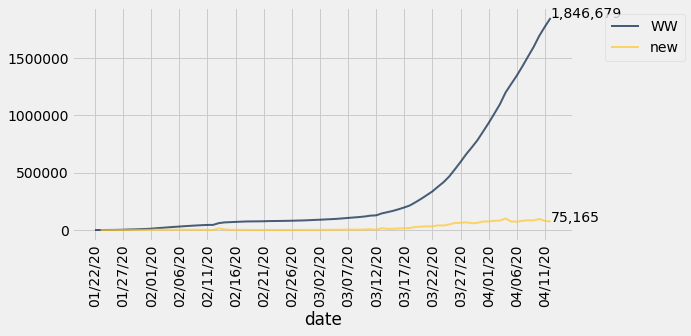

In [17]:
WW_cases = cases.select(cases.time_column)
WW_cases['WW'] = cases.sum_cols()

WW_deaths = deaths.select(cases.time_column)
WW_deaths['WW'] = deaths.sum_cols()

WW_case_trend = WW_cases.trend()
WW_all = WW_case_trend.extract(['WW', 'new'])
WW_all.oplot(width=8)
_ = plots.xticks(rotation=90)
plots.text(WW_all.last('date'), WW_all.last('WW'), "{:,}".format(WW_all.last('WW')))
plots.text(WW_all.last('date'), WW_all.last('new'), "{:,}".format(int(WW_all.last('new'))))
WW_all.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

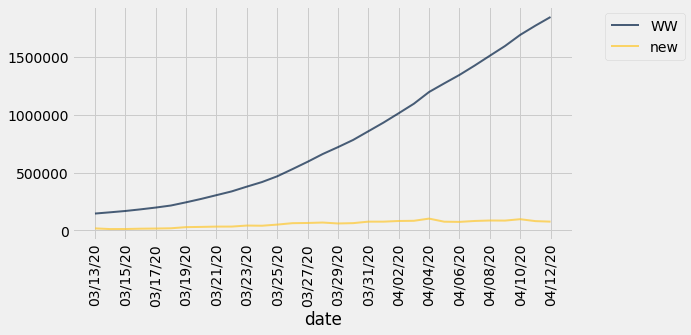

In [18]:
WW_recent = WW_case_trend.extract(['WW', 'new']).after("03/13/20")
WW_recent.oplot(width=8)
_ = plots.xticks(rotation=90)
WW_recent.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [19]:
WW_deaths['WW'][-1], WW_deaths['WW'][-1]/WW_cases['WW'][-1]

(114089, 0.061780634317063224)

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

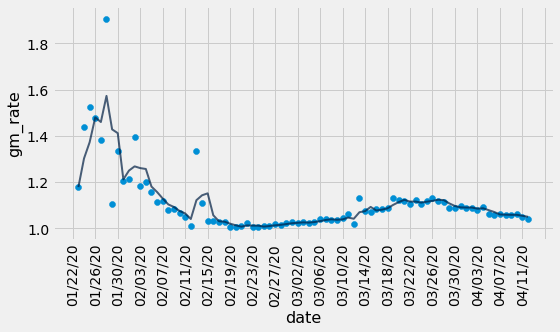

In [20]:
plot_rate_trend(WW_case_trend)

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

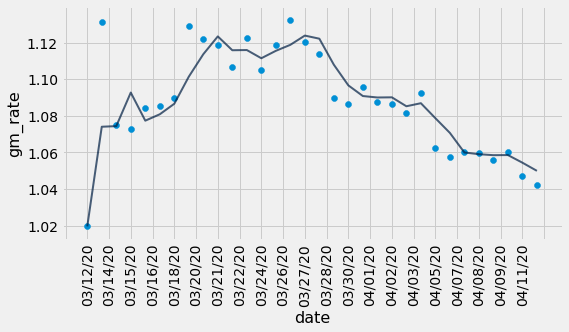

In [21]:
# Past month
plot_rate_trend(WW_case_trend.tail(31))

Taking just the past two week, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  The trends are so slow that we need to go out two months (an eternity) to see a notable difference.

[1.09704098 0.99656723] [ 1.09688189 -0.00368773]


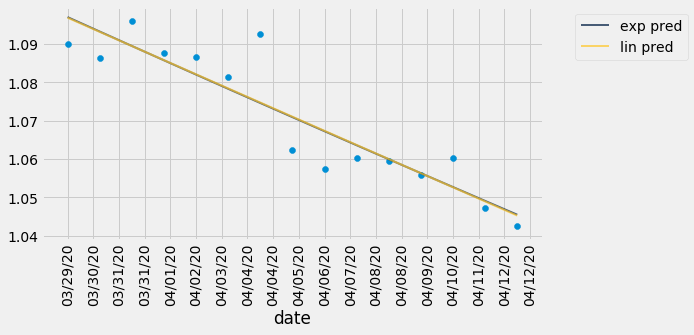

In [22]:
show_model_rate_trend(WW_case_trend.tail(14))

In [23]:
WW_rate_proj, eparams, lparams = model_rate_trend(WW_case_trend.tail(14))

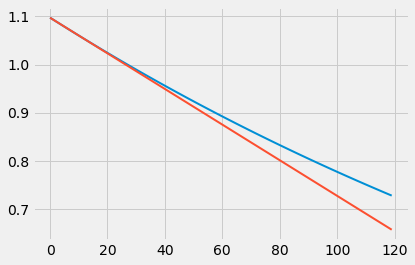

In [24]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(120)

## National Projections

Given some predictability, we can project grow rates into the future.  First we look projecting based on the current daily growth rate, modeling what things look like if we do just what we are seeing today, versus how they looked based on what we were seeing some days previously.

Then, given the steady reduction in rates, we project based on projecting the rate improving exponentially.

In [25]:
# Prediction going forward assuming the growth rate remains as it is currently

def proj_WW(prev=2, dist=14):
    proj2(WW_cases, 'WW', prev, dist)
    
_ = interact(proj_WW, prev=(0,7,1), dist = (3, 14, 1))

interactive(children=(IntSlider(value=2, description='prev', max=7), IntSlider(value=14, description='dist', m…

In [26]:
def project_progressive_trend(trend, region, num_days):
    day = trend.last(trend.time_column)
    val = trend.last(region)
    new = trend.last('new')
    rate = trend.last('rate')
    params, pcov = fit(exp_rate, trend)
    growths = exp_rate(range(num_days+1), rate, params[1])
    
    proj = trend.select([trend.time_column, region, 'new', 'rate'])
    for i in range(num_days):
        day = inc_day(day)
        rate = growths[i+1]
        new = rate*new
        val = val + new
        pnew = new/val
        proj.append((day, val, new, rate))
    return proj

def proj_prog(ts, region, prev=7, dist=14):
    trend = ts.trend().tail(prev)
    proj = project_progressive_trend(trend, region, dist)
    pproj = proj.select([proj.time_column, region, 'new']).tail(prev+dist)
    pproj.plot('date', width = 8)
    end = trend.last(trend.time_column)
    plots.plot([end, end], [0, trend.last(region)])
    pproj.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))
    plots.text(end, trend.last(region), "{:,}".format(trend.last(region)))
    plots.text(pproj.last('date'), pproj.last(region), "{:,}".format(int(pproj.last(region))))
    _ = plots.xticks(rotation=90)

In [27]:
def pproj_WW(prev=14, dist=14):
    proj_prog(WW_cases, 'WW', prev, dist)
    
_ = interact(pproj_WW, prev=(0,14,1), dist = (3, 45, 1))



interactive(children=(IntSlider(value=14, description='prev', max=14), IntSlider(value=14, description='dist',…

In [28]:
project_progressive_trend(WW_cases.trend().tail(7), 'WW', 14).show()

date,WW,new,rate
04/05/20,1.27212e+06,74707,1.06239
04/06/20,1.3451e+06,72986,1.05737
04/07/20,1.4261e+06,80995,1.06021
04/08/20,1.5111e+06,85008,1.05961
04/09/20,1.59535e+06,84246,1.05575
04/10/20,1.69172e+06,96369,1.06041
04/11/20,1.77151e+06,79795,1.04717
04/12/20,1.84668e+06,75165,1.04243
04/13/20,1.92486e+06,78183.4,1.04016
04/14/20,2.00601e+06,81145.6,1.03789


<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

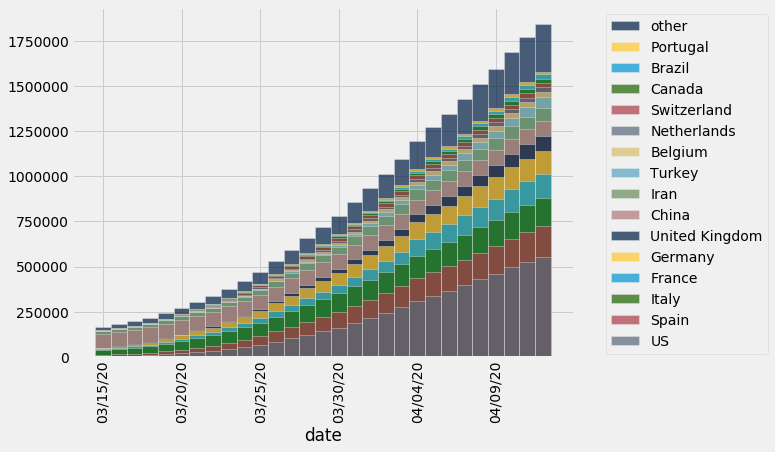

In [29]:
# Total US cases broken down by state
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

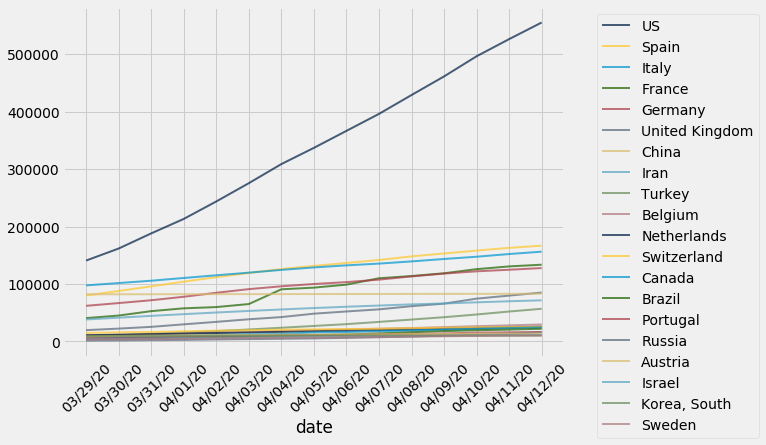

In [30]:
# Cases by state over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [31]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

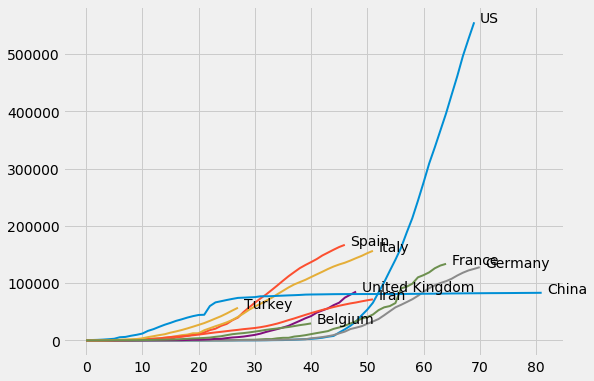

In [32]:
show_cases_since(cases.top(10), 10)

<a id='sectionTrends'></a>
## Growth trends by state

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [33]:
cases.order_cols().trend().tail(7)

date,US,new US,% newUS,rate US,Spain,new Spain,% newSpain,rate Spain,Italy,new Italy,% newItaly,rate Italy,France,new France,% newFrance,rate France,Germany,new Germany,% newGermany,rate Germany,United Kingdom,new United Kingdom,% newUnited Kingdom,rate United Kingdom,China,new China,% newChina,rate China,Iran,new Iran,% newIran,rate Iran,Turkey,new Turkey,% newTurkey,rate Turkey,Belgium,new Belgium,% newBelgium,rate Belgium,Netherlands,new Netherlands,% newNetherlands,rate Netherlands,Switzerland,new Switzerland,% newSwitzerland,rate Switzerland,Canada,new Canada,% newCanada,rate Canada,Brazil,new Brazil,% newBrazil,rate Brazil,Portugal,new Portugal,% newPortugal,rate Portugal,Russia,new Russia,% newRussia,rate Russia,Austria,new Austria,% newAustria,rate Austria,Israel,new Israel,% newIsrael,rate Israel,"Korea, South","new Korea, South","% newKorea, South","rate Korea, South",Sweden,new Sweden,% newSweden,rate Sweden,Ireland,new Ireland,% newIreland,rate Ireland,India,new India,% newIndia,rate India,Peru,new Peru,% newPeru,rate Peru,Ecuador,new Ecuador,% newEcuador,rate Ecuador,Chile,new Chile,% newChile,rate Chile,Japan,new Japan,% newJapan,rate Japan,Poland,new Poland,% newPoland,rate Poland,Norway,new Norway,% newNorway,rate Norway,Denmark,new Denmark,% newDenmark,rate Denmark,Australia,new Australia,% newAustralia,rate Australia,Romania,new Romania,% newRomania,rate Romania,Czechia,new Czechia,% newCzechia,rate Czechia,Pakistan,new Pakistan,% newPakistan,rate Pakistan,Malaysia,new Malaysia,% newMalaysia,rate Malaysia,Philippines,new Philippines,% newPhilippines,rate Philippines,Saudi Arabia,new Saudi Arabia,% newSaudi Arabia,rate Saudi Arabia,Indonesia,new Indonesia,% newIndonesia,rate Indonesia,Mexico,new Mexico,% newMexico,rate Mexico,United Arab Emirates,new United Arab Emirates,% newUnited Arab Emirates,rate United Arab Emirates,Serbia,new Serbia,% newSerbia,rate Serbia,Luxembourg,new Luxembourg,% newLuxembourg,rate Luxembourg,Panama,new Panama,% newPanama,rate Panama,Qatar,new Qatar,% newQatar,rate Qatar,Finland,new Finland,% newFinland,rate Finland,Dominican Republic,new Dominican Republic,% newDominican Republic,rate Dominican Republic,Ukraine,new Ukraine,% newUkraine,rate Ukraine,Colombia,new Colombia,% newColombia,rate Colombia,Belarus,new Belarus,% newBelarus,rate Belarus,Thailand,new Thailand,% newThailand,rate Thailand,Singapore,new Singapore,% newSingapore,rate Singapore,South Africa,new South Africa,% newSouth Africa,rate South Africa,Argentina,new Argentina,% newArgentina,rate Argentina,Greece,new Greece,% newGreece,rate Greece,Egypt,new Egypt,% newEgypt,rate Egypt,Algeria,new Algeria,% newAlgeria,rate Algeria,Iceland,new Iceland,% newIceland,rate Iceland,Moldova,new Moldova,% newMoldova,rate Moldova,Morocco,new Morocco,% newMorocco,rate Morocco,Croatia,new Croatia,% newCroatia,rate Croatia,Hungary,new Hungary,% newHungary,rate Hungary,Iraq,new Iraq,% newIraq,rate Iraq,New Zealand,new New Zealand,% newNew Zealand,rate New Zealand,Estonia,new Estonia,% newEstonia,rate Estonia,Kuwait,new Kuwait,% newKuwait,rate Kuwait,Slovenia,new Slovenia,% newSlovenia,rate Slovenia,Bahrain,new Bahrain,% newBahrain,rate Bahrain,Azerbaijan,new Azerbaijan,% newAzerbaijan,rate Azerbaijan,Lithuania,new Lithuania,% newLithuania,rate Lithuania,Armenia,new Armenia,% newArmenia,rate Armenia,Bosnia and Herzegovina,new Bosnia and Herzegovina,% newBosnia and Herzegovina,rate Bosnia and Herzegovina,Kazakhstan,new Kazakhstan,% newKazakhstan,rate Kazakhstan,Uzbekistan,new Uzbekistan,% newUzbekistan,rate Uzbekistan,North Macedonia,new North Macedonia,% newNorth Macedonia,rate North Macedonia,Cameroon,new Cameroon,% newCameroon,rate Cameroon,Slovakia,new Slovakia,% newSlovakia,rate Slovakia,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Tunisia,new Tunisia,% newTunisia,rate Tunisia,Bulgaria,new Bulgaria,% newBulgaria,rate Bulgaria,Cuba,new Cuba,% newCuba,rate Cuba,Latvia,new Latvia,% newLatvia,rate Latvia

In [34]:
def rate_change(ts, region_type, prev=7):
    rates   = get_rates(ts)
    regions = rates.categories
    current = rates.row(-1)[1:]
    older   = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

In [35]:
cases.trend()

date,Afghanistan,new Afghanistan,% newAfghanistan,rate Afghanistan,Albania,new Albania,% newAlbania,rate Albania,Algeria,new Algeria,% newAlgeria,rate Algeria,Andorra,new Andorra,% newAndorra,rate Andorra,Angola,new Angola,% newAngola,rate Angola,Antigua and Barbuda,new Antigua and Barbuda,% newAntigua and Barbuda,rate Antigua and Barbuda,Argentina,new Argentina,% newArgentina,rate Argentina,Armenia,new Armenia,% newArmenia,rate Armenia,Australia,new Australia,% newAustralia,rate Australia,Austria,new Austria,% newAustria,rate Austria,Azerbaijan,new Azerbaijan,% newAzerbaijan,rate Azerbaijan,Bahamas,new Bahamas,% newBahamas,rate Bahamas,Bahrain,new Bahrain,% newBahrain,rate Bahrain,Bangladesh,new Bangladesh,% newBangladesh,rate Bangladesh,Barbados,new Barbados,% newBarbados,rate Barbados,Belarus,new Belarus,% newBelarus,rate Belarus,Belgium,new Belgium,% newBelgium,rate Belgium,Belize,new Belize,% newBelize,rate Belize,Benin,new Benin,% newBenin,rate Benin,Bhutan,new Bhutan,% newBhutan,rate Bhutan,Bolivia,new Bolivia,% newBolivia,rate Bolivia,Bosnia and Herzegovina,new Bosnia and Herzegovina,% newBosnia and Herzegovina,rate Bosnia and Herzegovina,Botswana,new Botswana,% newBotswana,rate Botswana,Brazil,new Brazil,% newBrazil,rate Brazil,Brunei,new Brunei,% newBrunei,rate Brunei,Bulgaria,new Bulgaria,% newBulgaria,rate Bulgaria,Burkina Faso,new Burkina Faso,% newBurkina Faso,rate Burkina Faso,Burma,new Burma,% newBurma,rate Burma,Burundi,new Burundi,% newBurundi,rate Burundi,Cabo Verde,new Cabo Verde,% newCabo Verde,rate Cabo Verde,Cambodia,new Cambodia,% newCambodia,rate Cambodia,Cameroon,new Cameroon,% newCameroon,rate Cameroon,Canada,new Canada,% newCanada,rate Canada,Central African Republic,new Central African Republic,% newCentral African Republic,rate Central African Republic,Chad,new Chad,% newChad,rate Chad,Chile,new Chile,% newChile,rate Chile,China,new China,% newChina,rate China,Colombia,new Colombia,% newColombia,rate Colombia,Congo (Brazzaville),new Congo (Brazzaville),% newCongo (Brazzaville),rate Congo (Brazzaville),Congo (Kinshasa),new Congo (Kinshasa),% newCongo (Kinshasa),rate Congo (Kinshasa),Costa Rica,new Costa Rica,% newCosta Rica,rate Costa Rica,Cote d'Ivoire,new Cote d'Ivoire,% newCote d'Ivoire,rate Cote d'Ivoire,Croatia,new Croatia,% newCroatia,rate Croatia,Cuba,new Cuba,% newCuba,rate Cuba,Cyprus,new Cyprus,% newCyprus,rate Cyprus,Czechia,new Czechia,% newCzechia,rate Czechia,Denmark,new Denmark,% newDenmark,rate Denmark,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Djibouti,new Djibouti,% newDjibouti,rate Djibouti,Dominica,new Dominica,% newDominica,rate Dominica,Dominican Republic,new Dominican Republic,% newDominican Republic,rate Dominican Republic,Ecuador,new Ecuador,% newEcuador,rate Ecuador,Egypt,new Egypt,% newEgypt,rate Egypt,El Salvador,new El Salvador,% newEl Salvador,rate El Salvador,Equatorial Guinea,new Equatorial Guinea,% newEquatorial Guinea,rate Equatorial Guinea,Eritrea,new Eritrea,% newEritrea,rate Eritrea,Estonia,new Estonia,% newEstonia,rate Estonia,Eswatini,new Eswatini,% newEswatini,rate Eswatini,Ethiopia,new Ethiopia,% newEthiopia,rate Ethiopia,Fiji,new Fiji,% newFiji,rate Fiji,Finland,new Finland,% newFinland,rate Finland,France,new France,% newFrance,rate France,Gabon,new Gabon,% newGabon,rate Gabon,Gambia,new Gambia,% newGambia,rate Gambia,Georgia,new Georgia,% newGeorgia,rate Georgia,Germany,new Germany,% newGermany,rate Germany,Ghana,new Ghana,% newGhana,rate Ghana,Greece,new Greece,% newGreece,rate Greece,Grenada,new Grenada,% newGrenada,rate Grenada,Guatemala,new Guatemala,% newGuatemala,rate Guatemala,Guinea,new Guinea,% newGuinea,rate Guinea,Guinea-Bissau,new Guinea-Bissau,% newGuinea-Bissau,rate Guinea-Bissau,Guyana,new Guyana,% newGuyana,rate Guyana,Haiti,new Haiti,% newHaiti,rate Haiti,Holy See,new Holy See,% newHoly See,rate Holy See,Honduras,new Honduras,% newHonduras,rate Honduras,Hungary,new Hungary,% newHungary,rate Hungary,I

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [36]:
def irate(previous=7):
    show_rate_change(cases, 'State', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

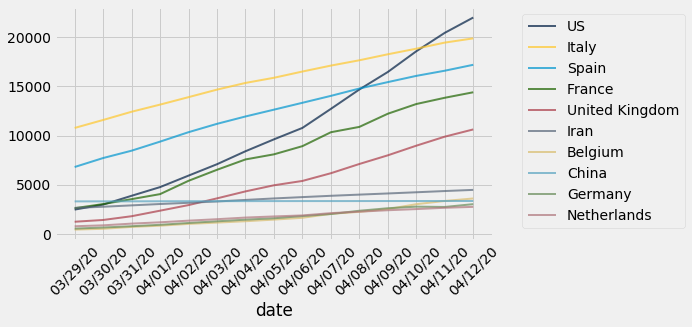

In [37]:
deaths.top(10).tail(14).plot('date', width=7)
_ = plots.xticks(rotation=45)

In [38]:
deaths.order_cols().trend().tail(7)

date,US,new US,% newUS,rate US,Italy,new Italy,% newItaly,rate Italy,Spain,new Spain,% newSpain,rate Spain,France,new France,% newFrance,rate France,United Kingdom,new United Kingdom,% newUnited Kingdom,rate United Kingdom,Iran,new Iran,% newIran,rate Iran,Belgium,new Belgium,% newBelgium,rate Belgium,China,new China,% newChina,rate China,Germany,new Germany,% newGermany,rate Germany,Netherlands,new Netherlands,% newNetherlands,rate Netherlands,Brazil,new Brazil,% newBrazil,rate Brazil,Turkey,new Turkey,% newTurkey,rate Turkey,Switzerland,new Switzerland,% newSwitzerland,rate Switzerland,Sweden,new Sweden,% newSweden,rate Sweden,Canada,new Canada,% newCanada,rate Canada,Portugal,new Portugal,% newPortugal,rate Portugal,Indonesia,new Indonesia,% newIndonesia,rate Indonesia,Austria,new Austria,% newAustria,rate Austria,Ireland,new Ireland,% newIreland,rate Ireland,Ecuador,new Ecuador,% newEcuador,rate Ecuador,India,new India,% newIndia,rate India,Romania,new Romania,% newRomania,rate Romania,Philippines,new Philippines,% newPhilippines,rate Philippines,Algeria,new Algeria,% newAlgeria,rate Algeria,Denmark,new Denmark,% newDenmark,rate Denmark,Mexico,new Mexico,% newMexico,rate Mexico,Poland,new Poland,% newPoland,rate Poland,"Korea, South","new Korea, South","% newKorea, South","rate Korea, South",Peru,new Peru,% newPeru,rate Peru,Dominican Republic,new Dominican Republic,% newDominican Republic,rate Dominican Republic,Egypt,new Egypt,% newEgypt,rate Egypt,Czechia,new Czechia,% newCzechia,rate Czechia,Russia,new Russia,% newRussia,rate Russia,Norway,new Norway,% newNorway,rate Norway,Morocco,new Morocco,% newMorocco,rate Morocco,Colombia,new Colombia,% newColombia,rate Colombia,Japan,new Japan,% newJapan,rate Japan,Israel,new Israel,% newIsrael,rate Israel,Hungary,new Hungary,% newHungary,rate Hungary,Greece,new Greece,% newGreece,rate Greece,Pakistan,new Pakistan,% newPakistan,rate Pakistan,Argentina,new Argentina,% newArgentina,rate Argentina,Ukraine,new Ukraine,% newUkraine,rate Ukraine,Chile,new Chile,% newChile,rate Chile,Serbia,new Serbia,% newSerbia,rate Serbia,Panama,new Panama,% newPanama,rate Panama,Iraq,new Iraq,% newIraq,rate Iraq,Malaysia,new Malaysia,% newMalaysia,rate Malaysia,Luxembourg,new Luxembourg,% newLuxembourg,rate Luxembourg,Australia,new Australia,% newAustralia,rate Australia,Saudi Arabia,new Saudi Arabia,% newSaudi Arabia,rate Saudi Arabia,Finland,new Finland,% newFinland,rate Finland,Slovenia,new Slovenia,% newSlovenia,rate Slovenia,Bosnia and Herzegovina,new Bosnia and Herzegovina,% newBosnia and Herzegovina,rate Bosnia and Herzegovina,Thailand,new Thailand,% newThailand,rate Thailand,San Marino,new San Marino,% newSan Marino,rate San Marino,Bangladesh,new Bangladesh,% newBangladesh,rate Bangladesh,North Macedonia,new North Macedonia,% newNorth Macedonia,rate North Macedonia,Moldova,new Moldova,% newMoldova,rate Moldova,Tunisia,new Tunisia,% newTunisia,rate Tunisia,Andorra,new Andorra,% newAndorra,rate Andorra,Bulgaria,new Bulgaria,% newBulgaria,rate Bulgaria,Burkina Faso,new Burkina Faso,% newBurkina Faso,rate Burkina Faso,Belarus,new Belarus,% newBelarus,rate Belarus,Estonia,new Estonia,% newEstonia,rate Estonia,Honduras,new Honduras,% newHonduras,rate Honduras,South Africa,new South Africa,% newSouth Africa,rate South Africa,Bolivia,new Bolivia,% newBolivia,rate Bolivia,Albania,new Albania,% newAlbania,rate Albania,Croatia,new Croatia,% newCroatia,rate Croatia,Lithuania,new Lithuania,% newLithuania,rate Lithuania,United Arab Emirates,new United Arab Emirates,% newUnited Arab Emirates,rate United Arab Emirates,Congo (Kinshasa),new Congo (Kinshasa),% newCongo (Kinshasa),rate Congo (Kinshasa),Lebanon,new Lebanon,% newLebanon,rate Lebanon,Afghanistan,new Afghanistan,% newAfghanistan,rate Afghanistan,Cuba,new Cuba,% newCuba,rate Cuba,Armenia,new Armenia,% newArmenia,rate Armenia,Cameroon,new Cameroon,% newCameroon,rate Cameroon,Niger,new Niger,% newNiger,rate Niger,Azerbaijan,new Azerbaijan,% newAzerba

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [52]:
def show_st(state='US', prev = 7):
    cases.extract(state).trend().tail(prev).show()
    cases.extract(state).trend().extract([state, 'new']).tail(21).plot('date', width=7)
    _ = plots.xticks(rotation=90)
    plot_rate_trend(cases.extract(state).trend().tail(prev))
    _ = plots.xticks(rotation=90)

_ = interact(show_st, state=states, prev = (7, 21, 1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

<a id='sectionProj'></a>
## Projection of cases in one state

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [40]:
def proj_st(state='US', dist=14):
    proj(cases, state, 7, dist)
    
_ = interact(proj_st, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

In [41]:
def proj_prog_st(state='US', dist=14):
    proj_prog(cases.extract(state), state, 7, dist)
    
_ = interact(proj_prog_st, state=states, dist = (7, 31, 1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

<a id='sectionProjDeath'></a>
## Projection of deaths in one state

In [42]:
def proj_st_deaths(state='US', dist=14):
    proj(deaths, state, 7, dist)

_ = interact(proj_st_deaths, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [43]:
def proj2_st(state='US', prev=2, dist=14):
    proj2(cases, state, prev, dist)
    
_ = interact(proj2_st, state=states, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

In [44]:
def proj2_st_deaths(state='US', prev=2):
    proj2(deaths, state, prev)
    
_ = interact(proj2_st_deaths, state=states, prev=(0,7,1))

interactive(children=(Dropdown(description='state', index=171, options=('Afghanistan', 'Albania', 'Algeria', '…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [45]:
get_rates(cases).tail(7)

date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Diamond Princess,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,MS Zaandam,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
04/05/20,1.16722,1.08408,1.05516,1.07511,1.4,1,1,1.06753,1.02468,1.02292,1.12092,1,1.01744,1.25714,1.07692,1.27727,1.06836,1.25,1.375,1,1.1295,1.04808,1.5,1.07432,1,1.05567,1.08491,1,1,1,1,1.17117,1.21405,1,1,1.0745,1.00071,1.05619,2.04545,1,1.04368,1.06531,1.04973,1.11111,1.04695,1.02572,1.0684,1,1.18,1,1.17272,1.05224,1.09626,1.10714,1,1,1.05582,1,1.13158,1,1.02391,1.0322,1,1,1.07407,1.04195,1.0439,1.03706,1,1,1.09009,1,1.04348,1.05,1,1.01515,1.08112,1.04869,1.16418,1.08652,1.04454,1.09453,1.08471,1.07375,1.03463,1.09434,1,1.06811,1.09981,1.12698,1.00798,1.07407,1.16075,1.02083,1.1,1.04715,1.01346,1.3,1,1,1.05188,1.02748,1,1.02857,1,1.05139,1,1.09756,1.06573,1,1.15816,1.11967,1.14894,1.10606,1,1.06468,1.11099,1,1.14286,1,1.07329,1.09368,1.2,1.27778,1.08411,1.14907,1.02468,1.07581,1.1203,1.07651,1,1.08333,1.30641,1.04913,1.13096,1.07165,1.21057,1.06947,1.13908,1.01961,1.11111,1,1,1.02703,nan,1.10234,1.0137,1.17488,1,1.5,1.10093,1.02972,1.02047,1,1.04416,inf,1.04342,1.06024,1.2,1,1.06007,1.02902,1.1875,1.02254,1.1,1.04935,1,1.07317,1.00971,1.03797,1.13099,1.09137,1.08333,1.06776,1.19535,1.14029,1,1.28571,1.02581,1.00417,1.09217,inf,nan,1,1
04/06/20,1.05158,1.04432,1.07803,1.0479,1.14286,1,1.07099,1.01338,1.01934,1.02041,1.0976,1.03571,1.08,1.39773,1.07143,1.24555,1.05703,1.4,1.18182,1,1.16561,1.03058,1,1.09263,1,1.0339,1.05507,1.04762,1,1,1,1.01231,1.05122,1,1,1.07694,1.00076,1.0633,1,1.04545,1.02863,1.23755,1.03384,1.09375,1.0426,1.05123,1.06884,1,1.52542,1.07143,1.04756,1.0277,1.12702,1.1129,1,1.06897,1.01003,1.11111,1.02326,1.16667,1.12922,1.05535,1.14286,1,1.08046,1.03247,1,1.01153,1,1.14754,1.05785,1,1.29167,1.14286,1,1.11194,1.01501,1.05114,1.33166,1.09591,1.03905,1.07284,1.07409,1.05623,1.02791,1,1.16406,1.01159,1.13356,1.11268,1.00459,1,1.19604,1.46939,1.09091,1.01689,1.02657,1.07692,1.05556,1,1.03946,1.01391,1,1.13889,1.25,1.03577,1,1.04444,1.06167,1,1.07489,1.13386,1.1169,1.05479,1.07143,1.08879,1.09696,1,1,1,1.0542,1.06449,1,1.375,1.02586,1.02703,1.0313,1.11074,1.1929,1.10383,2,1.08654,1.12275,1.12754,1.07582,1.04008,1.14214,1.04995,1.17703,1.00962,1,1,1,1,inf,1.08451,1.01802,1.15304,1.1,1,1.05042,1.10103,1.02407,1,1.01873,1,1.0382,1.01136,1,1,1.05505,1.0264,1,1.02755,1.09091,1.02351,1,1

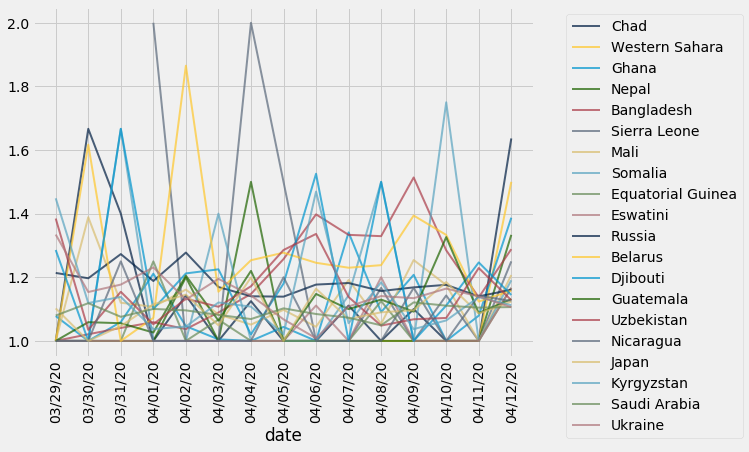

In [46]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

In [47]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def get_rate_slope(trend, region):
    params, pcov = fit(lin_rate, trend)
    return params[1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions],
    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff rate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

In [48]:
case_sum = summary(cases, 'state', states)
case_sum.sort('delta', descending=True)

/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


state,current,new,rate,eff rate,delta,err
Gambia,9,0,1,0.895833,0.0744048,0.0671019
Chad,18,7,1.63636,0.930051,0.0502525,0.0303069
Burundi,5,0,1,0.944444,0.0396825,0.0357877
Timor-Leste,2,0,1,1,0.0357143,0.0570932
Burma,41,3,1.07895,0.972552,0.0347472,0.0183812
Somalia,25,4,1.19048,1.0873,0.0316043,0.0451571
Nepal,12,3,1.33333,0.944444,0.0277778,0.0160375
Ghana,566,158,1.38725,1.06482,0.0225477,0.0235072
Guatemala,155,18,1.13139,1.07432,0.0149946,0.0141414
Ukraine,2777,266,1.10593,1.06351,0.0129229,0.00645127


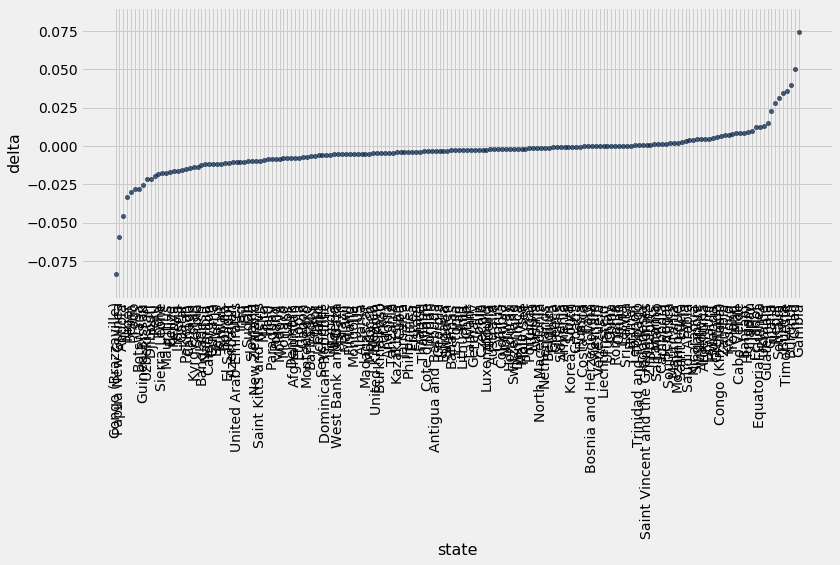

In [49]:
case_sum.select('state', 'delta').sort('delta').scatter('state', width=12)
_ = plots.xticks(rotation=90)

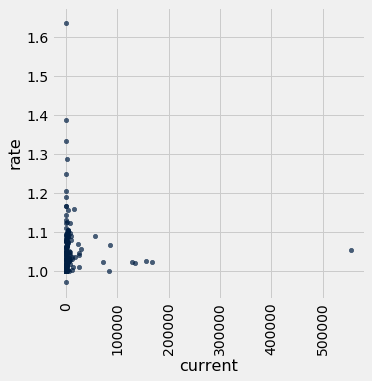

In [50]:
case_sum.scatter('current', 'rate')
_ = plots.xticks(rotation=90)

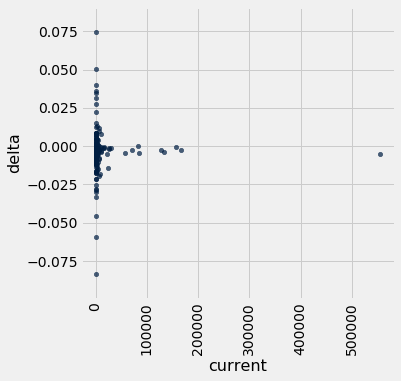

In [51]:
case_sum.scatter('current', 'delta')
_ = plots.xticks(rotation=90)